In [1]:
from ucimlrepo import fetch_ucirepo

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, SVMSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [3]:
# shape of the data
print(X.shape)
print(y.shape)

(45211, 16)
(45211, 1)


In [4]:
# summary statistics for features
X.describe()


,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
import pandas as pd

def display_missing_data_summary(X, y):
    # combine features and target for overview
    data = pd.concat([X, y], axis=1)

    # df for missing value summary
    missing_data = pd.DataFrame({
        'Variable': data.columns,
        'Data Type': data.dtypes,
        'Missing Values': data.isnull().sum(),
        'Total Entries': len(data)
    })

    # percentage of missing values
    missing_data['Missing (%)'] = (missing_data['Missing Values'] / missing_data['Total Entries']) * 100

    # sort by dataset (X vs y) and data type
    feature_vars = X.columns
    target_vars = y.columns

    print("==================== Missing Data Summary ====================\n")

    # features - grouped by data type
    print("============== Features (X) ==============\n")
    for dtype in missing_data[missing_data['Variable'].isin(feature_vars)]['Data Type'].unique():
        print(f"---- Data Type: {dtype} ----")
        subset = missing_data[(missing_data['Variable'].isin(feature_vars)) & 
                              (missing_data['Data Type'] == dtype)]
        print(subset.to_string(index=False))
        print()

    # target - grouped by data type
    print("============== Target (y) ==============\n")
    for dtype in missing_data[missing_data['Variable'].isin(target_vars)]['Data Type'].unique():
        print(f"---- Data Type: {dtype} ----")
        subset = missing_data[(missing_data['Variable'].isin(target_vars)) & 
                              (missing_data['Data Type'] == dtype)]
        print(subset.to_string(index=False))
        print()

    print("===============================================================\n")

# Call the function
display_missing_data_summary(X, y)


==================== Missing Data Summary ====================

============== Features (X) ==============

---- Data Type: int64 ----
   Variable Data Type  Missing Values  Total Entries  Missing (%)
        age     int64               0          45211          0.0
    balance     int64               0          45211          0.0
day_of_week     int64               0          45211          0.0
   duration     int64               0          45211          0.0
   campaign     int64               0          45211          0.0
      pdays     int64               0          45211          0.0
   previous     int64               0          45211          0.0

---- Data Type: object ----
 Variable Data Type  Missing Values  Total Entries  Missing (%)
      job    object             288          45211     0.637013
  marital    object               0          45211     0.000000
education    object            1857          45211     4.107407
  default    object               0          45211  

In [6]:
# clean columns
X_clean=X.copy()
X_clean['contact'] = X_clean['contact'].fillna('unknown')
X_clean['education'] = X_clean['education'].fillna('unknown')
X_clean['job'] = X_clean['job'].fillna('unknown')
X_clean = X_clean.drop(columns=['poutcome'])
X_clean.rename(columns={'day_of_week': 'day_of_month'}, inplace=True)

In [7]:
# Select categorical columns
categorical_columns = X_clean.select_dtypes(include=['object']).columns

# Print unique values for each categorical column with styled formatting
print("🔍 Unique values for each categorical column:\n")
for col in categorical_columns:
    unique_vals = X_clean[col].unique()
    print("=" * 50)
    print(f"📌 Column: {col}")
    print(f"🔢 Unique Count: {len(unique_vals)}")
    print(f"🧾 Unique Values: {unique_vals}")
    print("=" * 50 + "\n")

🔍 Unique values for each categorical column:

📌 Column: job
🔢 Unique Count: 12
🧾 Unique Values: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

📌 Column: marital
🔢 Unique Count: 3
🧾 Unique Values: ['married' 'single' 'divorced']

📌 Column: education
🔢 Unique Count: 4
🧾 Unique Values: ['tertiary' 'secondary' 'unknown' 'primary']

📌 Column: default
🔢 Unique Count: 2
🧾 Unique Values: ['no' 'yes']

📌 Column: housing
🔢 Unique Count: 2
🧾 Unique Values: ['yes' 'no']

📌 Column: loan
🔢 Unique Count: 2
🧾 Unique Values: ['no' 'yes']

📌 Column: contact
🔢 Unique Count: 3
🧾 Unique Values: ['unknown' 'cellular' 'telephone']

📌 Column: month
🔢 Unique Count: 12
🧾 Unique Values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']



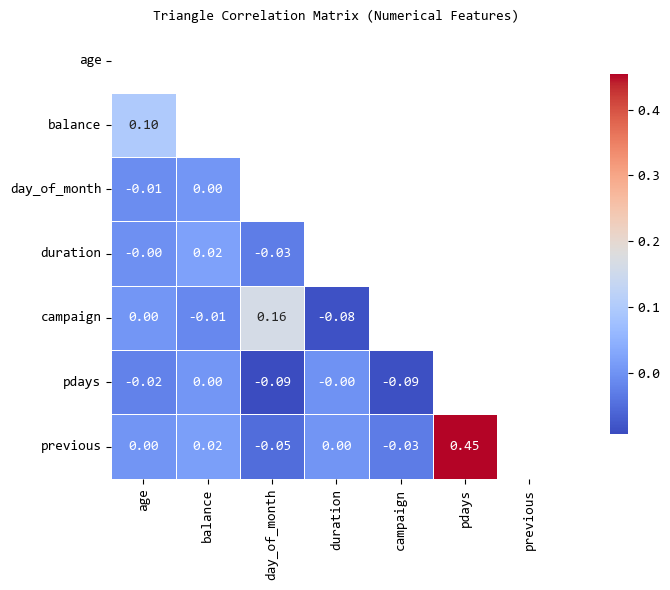

In [8]:
# Select only numeric features from the cleaned dataset
numeric_X = X_clean.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = numeric_X.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define font style
font = {'family': 'Consolas', 'size': 10}

# Apply font settings globally
plt.rc('font', **font)

# Generate a custom colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 10, "family": "Consolas"},
)

# Title and layout
plt.title("Triangle Correlation Matrix (Numerical Features)", fontsize=10, family='Consolas')
plt.xticks(fontsize=10, fontfamily='Consolas')
plt.yticks(fontsize=10, fontfamily='Consolas')
plt.tight_layout()
plt.show()

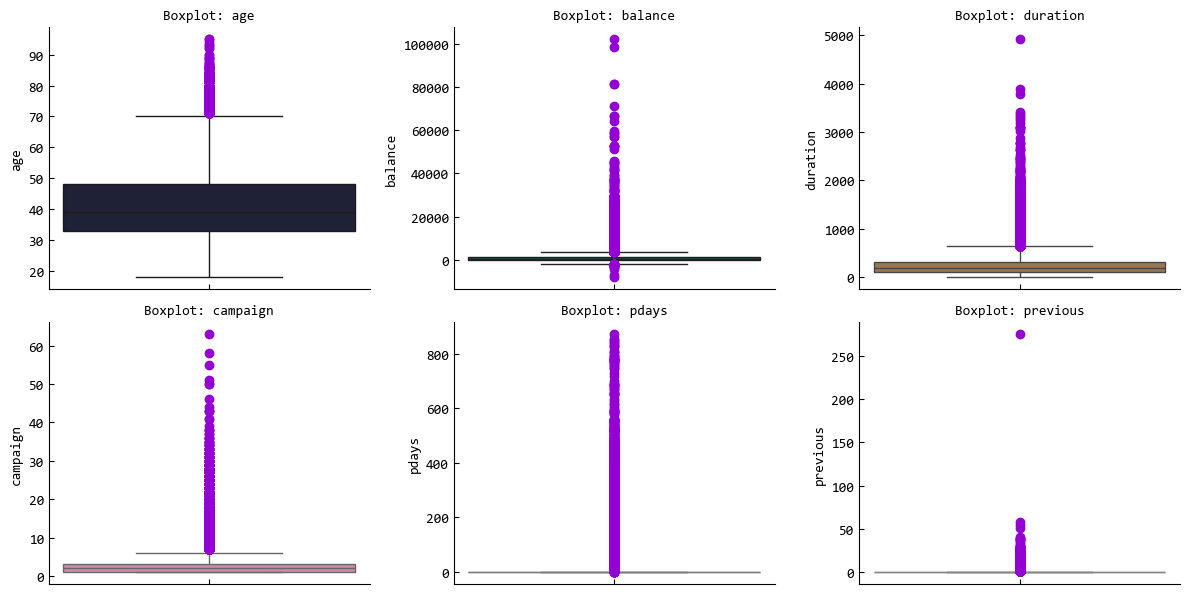

In [9]:
# Select numerical features
numeric_X = X_clean.select_dtypes(include=['int64', 'float64'])

# Grid setup: auto-calculate rows/cols
n_features = numeric_X.shape[1]
n_cols = 3  # You can change this
n_rows = int(np.ceil(n_features / n_cols))

# Set font globally
plt.rc('font', family='Consolas', size=10)

# Generate a vibrant gradient color palette
colors = sns.color_palette("cubehelix", n_colors=n_features)

# Professional color for outliers (dark blue or purple)
outlier_color = 'darkviolet'

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

plot_count = 0  # To track how many plots we actually create

# Plot boxplots only for columns with outliers
for i, column in enumerate(numeric_X.columns):
    # Calculate the IQR
    Q1 = numeric_X[column].quantile(0.25)
    Q3 = numeric_X[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Mask the outliers
    outliers = numeric_X[column][(numeric_X[column] < lower_bound) | (numeric_X[column] > upper_bound)]

    # Only plot if there are outliers
    if len(outliers) > 0:
        sns.boxplot(
            y=numeric_X[column], ax=axes[plot_count], color=colors[i], 
            flierprops=dict(marker='o', color=outlier_color, markersize=5)  # Color outliers darkviolet
        )
        
        # Mark the outliers explicitly
        axes[plot_count].scatter([0] * len(outliers), outliers, color=outlier_color, label='Outliers', zorder=3)
        
        axes[plot_count].set_title(f"Boxplot: {column}", fontsize=10, fontfamily='Consolas')
        axes[plot_count].set_ylabel(column, fontsize=10, fontfamily='Consolas')
        axes[plot_count].set_xlabel("")  # No x-label needed

        # Remove grid and background
        axes[plot_count].grid(False)  # No grid
        axes[plot_count].set_facecolor('white')  # White background for each plot
        sns.despine(ax=axes[plot_count])  # Remove top and right spines
        
        # Set ticks font
        axes[plot_count].tick_params(axis='both', which='major', labelsize=10, labelcolor='black', direction='in')

        plot_count += 1  # Increment plot counter

# Hide unused subplots if any
for j in range(plot_count, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

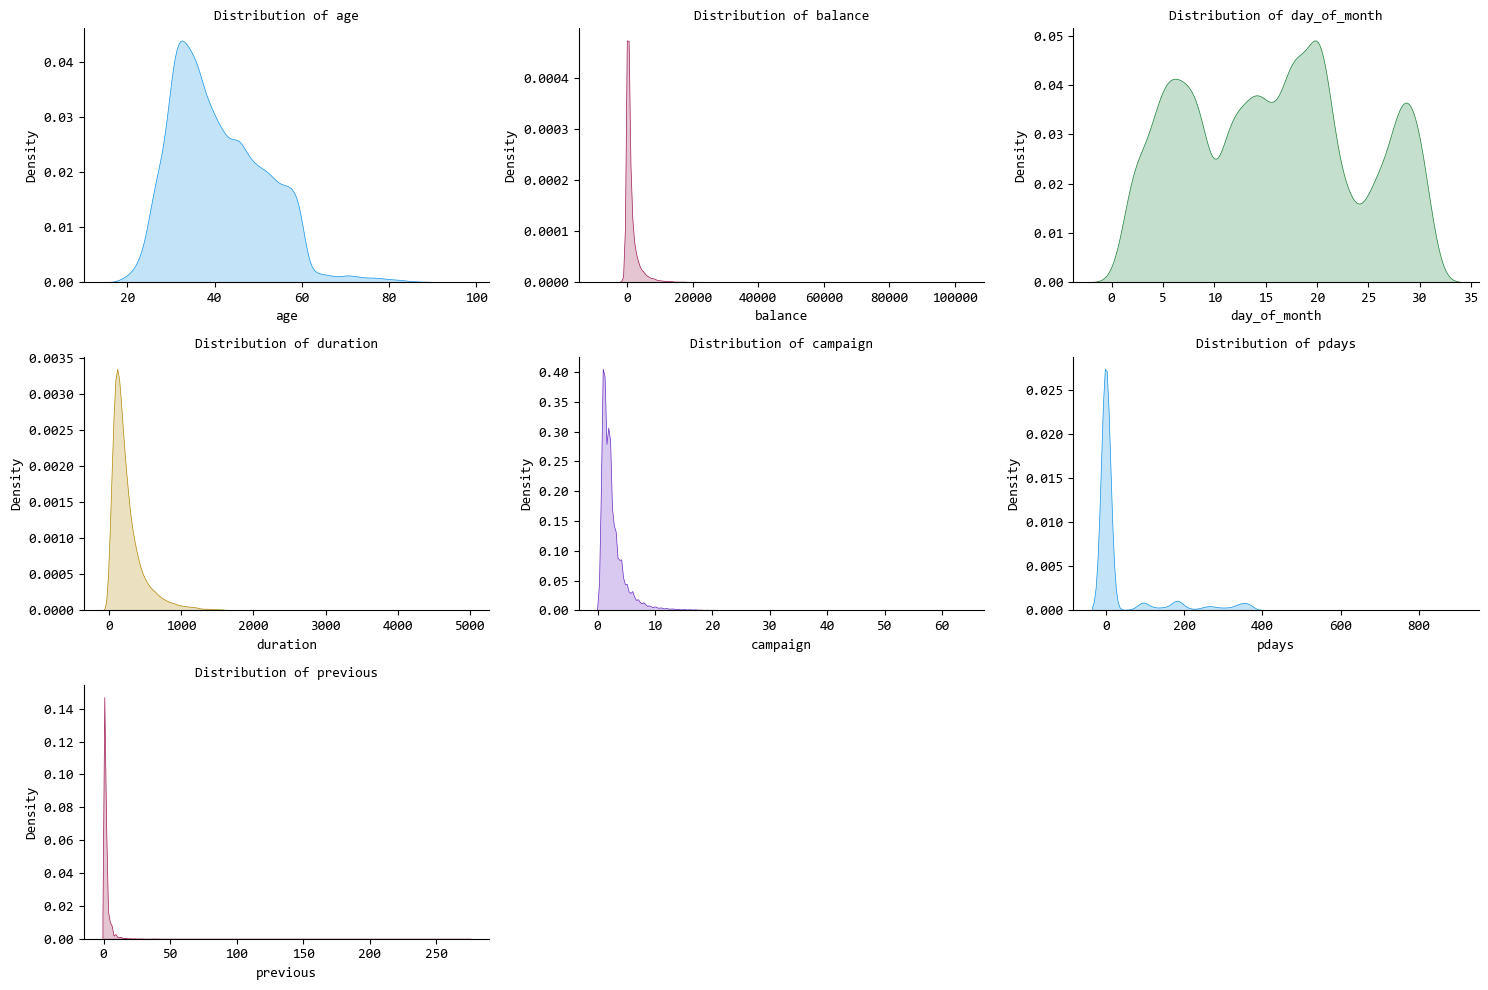

In [10]:
def plot_kde_with_custom_colors(data, numeric_columns, custom_palette, plot_size=(15, 10)):
    # Set up the matplotlib figure
    plt.figure(figsize=plot_size)

    # Plot KDE for each numeric column with custom colors
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(3, 3, i)  # Adjust the grid size for more plots
        sns.kdeplot(data[column], fill=True, color=custom_palette[i % len(custom_palette)], linewidth=0.5)
        plt.title(f'Distribution of {column}', fontsize=10, family='Consolas')
        plt.xlabel(f'{column}', fontsize=10, family='Consolas')
        plt.ylabel('Density', fontsize=10, family='Consolas')
        plt.xticks(fontsize=10, color='black', fontname='Consolas')
        plt.yticks(fontsize=10, color='black', fontname='Consolas')

        # Remove gridlines and background
        plt.grid(False)  # No grid
        plt.gca().set_facecolor('white')  # Set background to white
        sns.despine()  # Remove top and right spines

    plt.tight_layout()
    plt.show()

# Example usage:
custom_palette = ["#6929c4", "#1192e8", "#9f1853", "#198038", "#b28600"]

# Select only numeric columns from X_clean
numeric_columns = X_clean.select_dtypes(include=['int64', 'float64']).columns

# Call the function
plot_kde_with_custom_colors(X_clean, numeric_columns, custom_palette)

In [11]:
# Check unique entries in y by accessing the 'y' column in the DataFrame
print(y['y'].unique())

['no' 'yes']


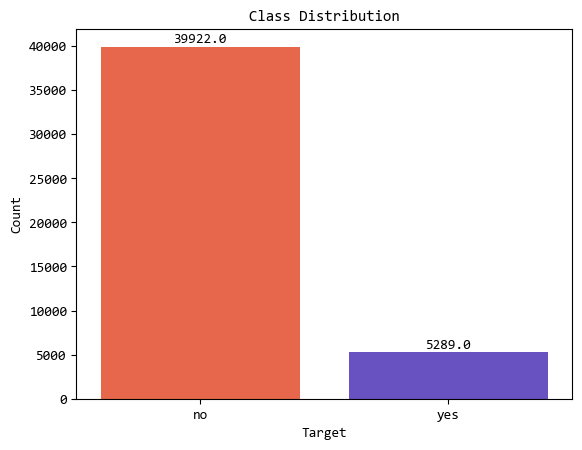

In [12]:
# Class imbalance plot for the target variable 'y'
sns.countplot(data=y, x='y', hue='y', palette={'no': '#FF5733', 'yes': '#5D3FD3'}, legend=False)

# Customize plot appearance
plt.title("Class Distribution", fontsize=11, color='black', fontname='Consolas')
plt.xlabel('Target', fontsize=10, color='black', fontname='Consolas')
plt.ylabel('Count', fontsize=10, color='black', fontname='Consolas')
plt.xticks(fontsize=10, color='black', fontname='Consolas')
plt.yticks(fontsize=10, color='black', fontname='Consolas')

# Remove background and grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Add value annotations on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', fontsize=10, color='black', fontname='Consolas', xytext=(0, 5), textcoords='offset points')

# Show plot
plt.show()

In [13]:
# Convert target variable to numerical using .loc
y.loc[:, 'y'] = y['y'].map({'yes': 1, 'no': 0})

# Define categorical columns to encode
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_month', 'default', 'housing', 'loan']

# One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)],
    remainder='passthrough'  # Leave other columns as they are
)

# Assuming X_clean is your features DataFrame
X_encoded = preprocessor.fit_transform(X_clean)

# Convert the sparse matrix to a dense array and create a DataFrame
X_encoded_dense = X_encoded.toarray()
X_encoded_df = pd.DataFrame(X_encoded_dense)

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y['y'], test_size=0.2, random_state=42, stratify=y)

In [15]:
# Explicitly convert y_train and y_test to integer NumPy arrays
y_train = y_train.values.astype(int)
y_test = y_test.values.astype(int)

In [16]:
# Scale the features to avoid convergence issues with some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define balancing techniques
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)
adasyn = ADASYN(random_state=42)
borderline_smote = BorderlineSMOTE(random_state=42)
svm_smote = SVMSMOTE(random_state=42)

# Apply each balancing technique
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train_scaled, y_train)
X_train_svm_smote, y_train_svm_smote = svm_smote.fit_resample(X_train_scaled, y_train)

In [17]:
# Store the balanced datasets in a dictionary
balanced_data = {
    'SMOTE': (X_train_smote, y_train_smote),
    'Random OverSampling': (X_train_ros, y_train_ros),
    'ADASYN': (X_train_adasyn, y_train_adasyn),
    'Borderline SMOTE': (X_train_borderline_smote, y_train_borderline_smote),
    'SVM SMOTE': (X_train_svm_smote, y_train_svm_smote)
}

In [18]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'KNN': KNeighborsClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Evaluate each model on every balanced dataset
print("🔍 Starting model evaluation on all balanced datasets...\n")

for technique_name, (X_bal, y_bal) in balanced_data.items():
    print(f"\n📊 Evaluating Models for: {technique_name}\n{'-'*50}")

    for model_name, model in models.items():
        print(f"\n➡️ Training model: {model_name}")

        # Train the model on the balanced dataset
        model.fit(X_bal, y_bal)

        # Predict using the test set
        y_pred = model.predict(X_test_scaled)

        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Accuracy: {acc:.4f}")

        # Display detailed classification report
        print(f"\n📝 Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred))

print("\n✅ All model evaluations complete.")

🔍 Starting model evaluation on all balanced datasets...


📊 Evaluating Models for: SMOTE
--------------------------------------------------

➡️ Training model: Logistic Regression
✅ Accuracy: 0.8353

📝 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7985
           1       0.40      0.80      0.53      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.82      0.72      9043
weighted avg       0.90      0.84      0.86      9043


➡️ Training model: Random Forest
✅ Accuracy: 0.8995

📝 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7985
           1       0.58      0.49      0.53      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.72      0.74      9043
weighted avg       0.89      0.90      0.90      9043